In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/data.csv')
data.dropna(axis=0)
data.head()

,Date,Close,Open,High,Low,Volume
0,2010.1.4,81.51,79.63,81.79,79.63,263.54K
1,2010.1.5,81.77,81.63,82.00,80.95,258.89K
2,2010.1.6,83.18,81.43,83.52,80.85,370.06K
3,2010.1.7,82.66,83.20,83.36,82.26,246.63K
4,2010.1.8,82.75,82.65,83.47,81.80,310.38K


In [3]:
#데이터 구성

high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [4]:
#윈도우 만들기
#최근 28일간 데이터를 보고 내일을 예측함

seq_len = 28
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [5]:
#데이터 정규화
#첫번째 값 0 윈도우의 값을 정규화함
#10/01, 10/02라면 첫번째는 0, 두번째는 (02/01) -1

normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

In [6]:

row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((2409, 28, 1), (268, 28, 1))

In [7]:
#LSTM 모델

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(28, 1))) #return_sequences=True는 상태유지
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear')) #다음날 하루
model.compile(loss='mse', optimizer='rmsprop')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 28, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [8]:
#LSTM 학습

model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         batch_size = 10,
         epochs = 20)

Train on 2409 samples, validate on 268 samples
Epoch 1/20
2409/2409 [==============================] - 4s 2ms/step - loss: 0.0015 - val_loss: 0.0053
Epoch 2/20
2409/2409 [==============================] - 3s 1ms/step - loss: 8.6925e-04 - val_loss: 0.0057
Epoch 3/20
2409/2409 [==============================] - 3s 1ms/step - loss: 7.3826e-04 - val_loss: 0.0037
Epoch 4/20
2409/2409 [==============================] - 3s 1ms/step - loss: 6.0959e-04 - val_loss: 0.0025
Epoch 5/20
2409/2409 [==============================] - 3s 1ms/step - loss: 5.9476e-04 - val_loss: 0.0029
Epoch 6/20
2409/2409 [==============================] - 4s 1ms/step - loss: 5.4680e-04 - val_loss: 0.0036
Epoch 7/20
2409/2409 [==============================] - 4s 1ms/step - loss: 5.4561e-04 - val_loss: 0.0029
Epoch 8/20
2409/2409 [==============================] - 4s 1ms/step - loss: 5.0628e-04 - val_loss: 0.0027
Epoch 9/20
2409/2409 [==============================] - 3s 1ms/step - loss: 4.9254e-04 - val_loss: 0.0024
Epo

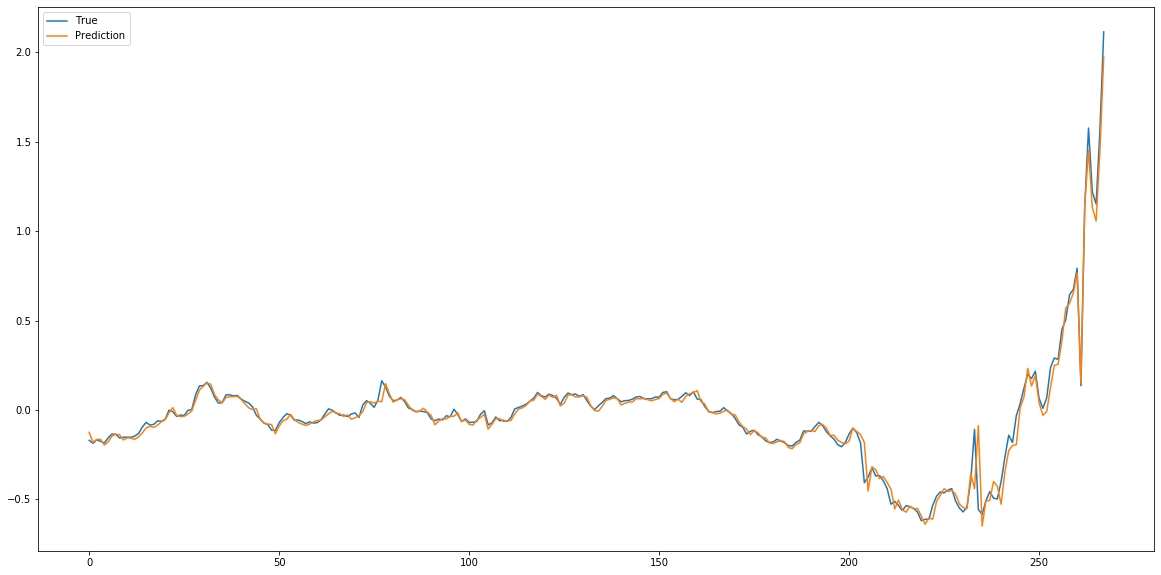

In [9]:
#LSTM 예측

pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()